<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/drewalessi/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enable and Verify GPU Acceleration

In [1]:
# Verify GPU availability
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Install library
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.5 MB/s eta 0:00:00


Load Image

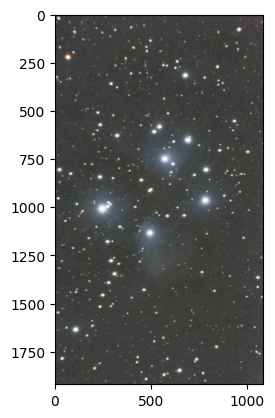

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

# Raw URL of FITS file on GitHub
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/10.fits"

# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))

Count the Stars

In [18]:
# Calculate the mean of the RGB channels, red, green, and blue channels
avg_channel = np.mean(rgb_data[:, :, :], axis=2)
red_channel = rgb_data[:, :, 0]  # Index 0 for red in RGB format
green_channel = rgb_data[:, :, 1]  # Index 1 for green in RGB format
blue_channel = rgb_data[:, :, 2]  # Index 2 for blue in RGB format

def detect_stars(channel_data):
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=5.0*std, brightest=600)
    return finder(channel_data - median)

# Detect stars
avg_sources = detect_stars(avg_channel)
print(f"Number of detected stars (average): {len(avg_sources)}")
red_sources = detect_stars(red_channel)
print(f"Number of detected stars (red): {len(red_sources)}")
green_sources = detect_stars(green_channel)
print(f"Number of detected stars (green): {len(green_sources)}")
blue_sources = detect_stars(blue_channel)
print(f"Number of detected stars (blue): {len(blue_sources)}")

Number of detected stars (average): 600
Number of detected stars (red): 600
Number of detected stars (green): 600
Number of detected stars (blue): 600


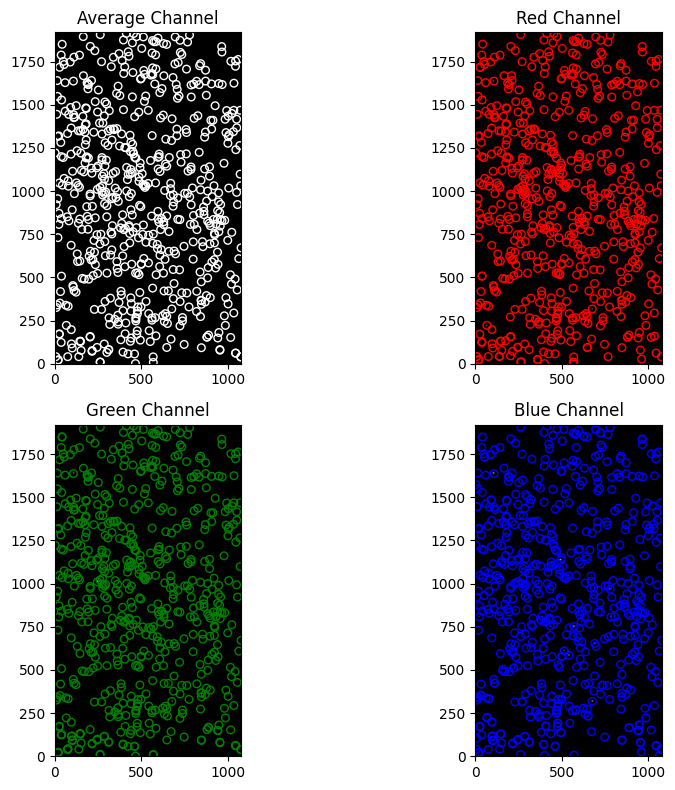

In [19]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot average channel
axs[0, 0].imshow(avg_channel, cmap='gray', origin='lower')
axs[0, 0].scatter(avg_sources['xcentroid'], avg_sources['ycentroid'],
                 s=30, edgecolor='white', facecolors='none')
axs[0, 0].set_title('Average Channel')

# Plot red channel
axs[0, 1].imshow(red_channel, cmap='gray', origin='lower')
axs[0, 1].scatter(red_sources['xcentroid'], red_sources['ycentroid'],
                 s=30, edgecolor='red', facecolors='none')
axs[0, 1].set_title('Red Channel')

# Plot green channel
axs[1, 0].imshow(green_channel, cmap='gray', origin='lower')
axs[1, 0].scatter(green_sources['xcentroid'], green_sources['ycentroid'],
                 s=30, edgecolor='green', facecolors='none')
axs[1, 0].set_title('Green Channel')

# Plot blue channel
axs[1, 1].imshow(blue_channel, cmap='gray', origin='lower')
axs[1, 1].scatter(blue_sources['xcentroid'], blue_sources['ycentroid'],
                 s=30, edgecolor='blue', facecolors='none')
axs[1, 1].set_title('Blue Channel')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [32]:
# Extract features (brightness and size)
flux = avg_sources['flux']
rflux = red_sources['flux']
gflux = green_sources['flux']
bflux = blue_sources['flux']

# Compute size proxy
size = avg_sources['sharpness']
rsize = red_sources['sharpness']
gsize = green_sources['sharpness']
bsize = blue_sources['sharpness']

# Normalize features
flux_norm = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
size_norm = (size - np.min(size)) / (np.max(size) - np.min(size))
rflux_norm = (rflux - np.min(rflux)) / (np.max(rflux) - np.min(rflux))
rsize_norm = (rsize - np.min(rsize)) / (np.max(rsize) - np.min(rsize))
gflux_norm = (gflux - np.min(gflux)) / (np.max(gflux) - np.min(gflux))
gsize_norm = (gsize - np.min(gsize)) / (np.max(gsize) - np.min(gsize))
bflux_norm = (bflux - np.min(bflux)) / (np.max(bflux) - np.min(bflux))
bsize_norm = (bsize - np.min(bsize)) / (np.max(bsize) - np.min(bsize))

features = np.vstack([flux_norm, size_norm]).T
rfeatures = np.vstack([rflux_norm, rsize_norm]).T
gfeatures = np.vstack([gflux_norm, gsize_norm]).T
bfeatures = np.vstack([bflux_norm, bsize_norm]).T

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Get star coordinates
xcentroids = avg_sources['xcentroid']
ycentroids = avg_sources['ycentroid']

# Extract color values at star locations
red = rgb_data[ycentroids.astype(int), xcentroids.astype(int), 0]  # Red channel
green = rgb_data[ycentroids.astype(int), xcentroids.astype(int), 1]  # Green channel
blue = rgb_data[ycentroids.astype(int), xcentroids.astype(int), 2]  # Blue channel

# Compute color ratios (add epsilon to avoid division by zero)
epsilon = 1e-10  # Small constant for numerical stability
r_g_ratio = (red + epsilon) / (green + epsilon)
b_g_ratio = (blue + epsilon) / (green + epsilon)

# Normalize features using MinMax scaling
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(np.vstack([r_g_ratio, b_g_ratio]).T)

# Extract normalized ratios
r_g_norm = normalized_features[:, 0]
b_g_norm = normalized_features[:, 1]

# Combined feature matrix
color_features = np.vstack([r_g_norm, b_g_norm]).T


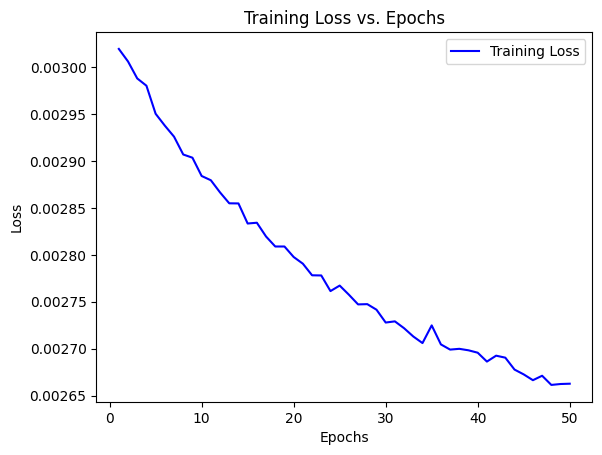

In [38]:
# Define an autoencoder model
input_layer = Input(shape=(2,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(2, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(color_features, color_features, epochs=50, batch_size=16, verbose=0)


#plot autoencoder loss
history = autoencoder.fit(color_features, color_features, epochs=50, batch_size=16, verbose=0)
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
encoder = Model(input_layer, encoded)
encoded_color_features = encoder.predict(color_features)

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(encoded_color_features)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


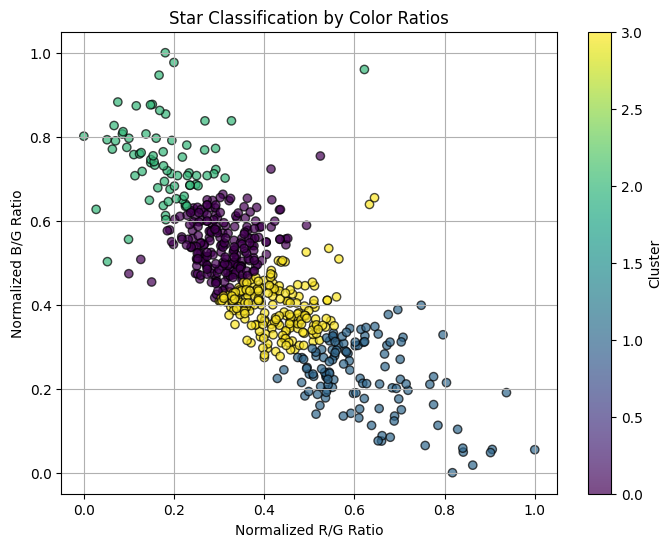

In [40]:

plt.figure(figsize=(8,6))
plt.scatter(r_g_norm, b_g_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Color Ratios')
plt.grid(True)
plt.show()

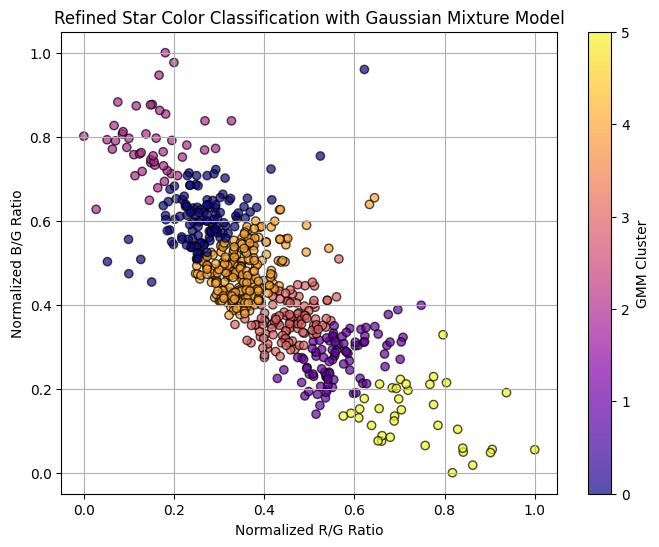

In [49]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters
num_clusters_gmm = 6
gmm = GaussianMixture(n_components=num_clusters_gmm, random_state=42)
predicted_labels_gmm = gmm.fit_predict(encoded_color_features)

plt.figure(figsize=(8,6))
plt.scatter(r_g_norm, b_g_norm, c=predicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Color Classification with Gaussian Mixture Model')
plt.grid(True)
plt.show()

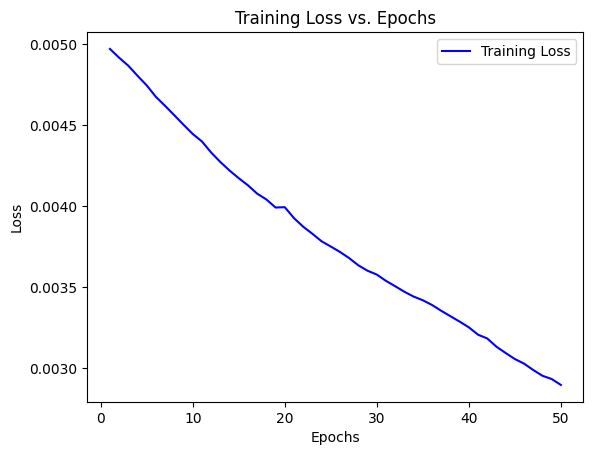

In [45]:
# Define an autoencoder model
finput_layer = Input(shape=(2,))
fencoded = Dense(8, activation='relu')(finput_layer)
fencoded = Dense(2, activation='relu')(fencoded)

fdecoded = Dense(8, activation='relu')(fencoded)
fdecoded = Dense(2, activation='sigmoid')(fdecoded)

fautoencoder = Model(finput_layer, fdecoded)
fautoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
fautoencoder.fit(features, features, epochs=50, batch_size=16, verbose=0)

#plot autoencoder loss
history = fautoencoder.fit(features, features, epochs=50, batch_size=16, verbose=0)
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
fencoder = Model(finput_layer, fencoded)
fencoded_features = fencoder.predict(features)

fnum_clusters = 4
fkmeans = KMeans(n_clusters=fnum_clusters, random_state=42)
fpredicted_labels = kmeans.fit_predict(fencoded_features)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


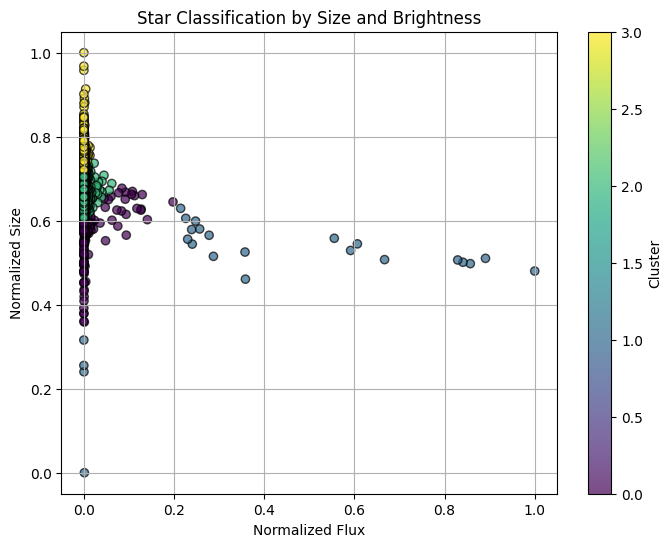

In [47]:

plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=fpredicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Flux')
plt.ylabel('Normalized Size')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Size and Brightness')
plt.grid(True)
plt.show()

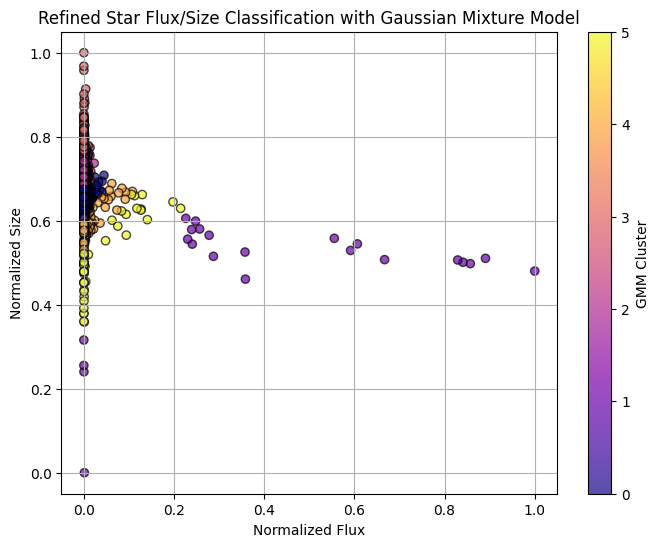

In [48]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters
fnum_clusters_gmm = 6
fgmm = GaussianMixture(n_components=fnum_clusters_gmm, random_state=42)
fpredicted_labels_gmm = gmm.fit_predict(fencoded_features)

plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=fpredicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Flux')
plt.ylabel('Normalized Size')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Flux/Size Classification with Gaussian Mixture Model')
plt.grid(True)
plt.show()